In [1]:
import torch
import torchvision

# you can use torchvision instead of albumentations,
# but remember to convert to PIL.Image first
import albumentations
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import os
import pandas as pd

import unitopatho

In [2]:
# Insert your path here!
path = '/data02/unitopath-public/800'

## Introduction

In [3]:
df = pd.read_csv(os.path.join(path, 'train.csv'))
df.head()

,image_id,top_label_name,top_label,type_name,type,grade_name,grade,wsi,roi,mpp,x,y,w,h
0,TVA.LG CASO 2 - 2018-12-04 13.19.16.ndpi_ROI__...,TVA.LG,5,TVA,3,LG,0,TVA.LG CASO 2 - 2018-12-04 13.19.16,0,0.44,9060,9947,1812,1812
1,TVA.LG CASO 11.ndpi_ROI__mpp0.44_reg000_crop_s...,TVA.LG,5,TVA,3,LG,0,TVA.LG CASO 11,0,0.44,53495,17309,1812,1812
2,174-B4-TVALG.ndpi_ROI__mpp0.44_reg005_crop_sk0...,TVA.LG,5,TVA,3,LG,0,174-B4-TVALG,5,0.44,22250,13632,1812,1812
3,209-B5-TVALG.ndpi_ROI__mpp0.44_reg000_crop_sk0...,TVA.LG,5,TVA,3,LG,0,209-B5-TVALG,0,0.44,8518,22889,1812,1812
4,178-B4-TVALG.ndpi_ROI__mpp0.44_reg000_crop_sk0...,TVA.LG,5,TVA,3,LG,0,178-B4-TVALG,0,0.44,31838,38479,1812,1812


There are 3 different labels: 

- top_label: [0, 5] -> HP, NORM, TA.HG, TA.LG, TVA.HG, TVA.LG
- type: [0, 3] -> HP, NORM, TA, TVA
- grade: {0, 1} -> LG, HG (NaN for HP and NORM samples)

*top_label* is used for the 6-class classification, *type* is referred to the tissue/adenoma type and *grade* to adenomas dysplasia grade.

Each target has a corresponding *_name* attribute containing the class actual name, e.g.

In [4]:
df.groupby('top_label_name').count()

,image_id,top_label,type_name,type,grade_name,grade,wsi,roi,mpp,x,y,w,h
top_label_name,,,,,,,,,,,,,
HP,443,443,443,443,0,443,443,443,443,443,443,443,443
NORM,724,724,724,724,0,724,724,724,724,724,724,724,724
TA.HG,333,333,333,333,333,333,333,333,333,333,333,333,333
TA.LG,2532,2532,2532,2532,2532,2532,2532,2532,2532,2532,2532,2532,2532
TVA.HG,465,465,465,465,465,465,465,465,465,465,465,465,465
TVA.LG,1773,1773,1773,1773,1773,1773,1773,1773,1773,1773,1773,1773,1773


## Class mapping

Use this mapping to convert from integer label to class name

In [5]:
top_label_mapping = {
    0: 'HP',
    1: 'NORM',
    2: 'TA.HG', 
    3: 'TA.LG',
    4: 'TVA.HG',
    5: 'TVA.LG'
}

type_mapping = {
    0: 'HP',
    1: 'NORM',
    2: 'TA',
    3: 'TVA'
}

grade_mapping = {
    0: 'LG',
    1: 'HG'
}

## 6-class loading example

In [6]:
T = albumentations.Compose([
    # Dont forget to normalize
    ToTensorV2()
])
transform = lambda x: T(image=x)['image']

In [7]:
dataset = unitopatho.UTP(df, path=path, T=transform, subsample=-1, target='top_label')
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=6, num_workers=2, pin_memory=True)

Loaded 6270 images


In [8]:
batch = next(iter(dataloader))

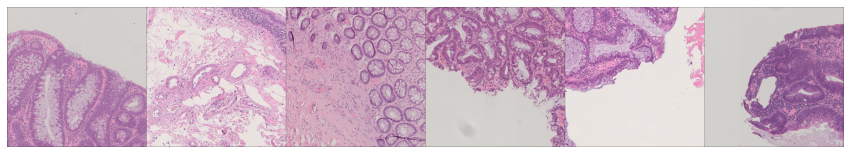

Labels: ['TA.LG', 'TA.LG', 'NORM', 'TA.HG', 'TA.LG', 'TVA.HG']


In [9]:
data, labels = batch
grid = torchvision.utils.make_grid(data)

plt.figure(figsize=(15, 5))
plt.axis('off')
plt.imshow(grid.permute(1, 2, 0))
plt.show()

print('Labels:', list(top_label_mapping[l.item()] for l in labels))

Images are loaded at full-resolution. If you want a downsampled version, e.g. 224x224 use the *subsample=224* parameter instead of *albumentations.Resize* or *torchvision*. The folder *7000_224* provides images extracted at $\alpha=7000$ already downsampled to 224x224 for convenience.

## Type loading example

Loaded 6270 images


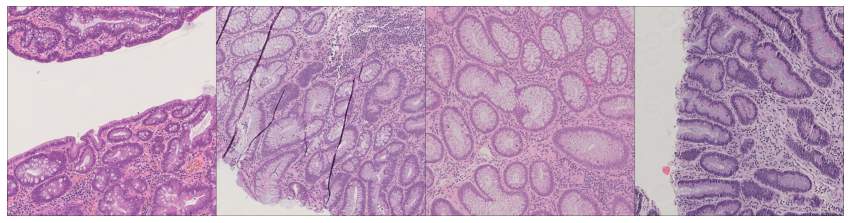

Labels: ['TVA', 'TA', 'TA', 'TA']


In [10]:
dataset = unitopatho.UTP(df, path=path, T=transform, subsample=-1, target='type')
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=4, num_workers=2, pin_memory=True)
batch = next(iter(dataloader))

data, labels = batch
grid = torchvision.utils.make_grid(data)

plt.figure(figsize=(15, 5))
plt.axis('off')
plt.imshow(grid.permute(1, 2, 0))
plt.show()

print('Labels:', list(type_mapping[l.item()] for l in labels))

## Grade loading example

For loading LG and HG samples, you must first exclude NORM and HP images from the set

In [11]:
df = df[df.grade >= 0].copy()

Loaded 5103 images


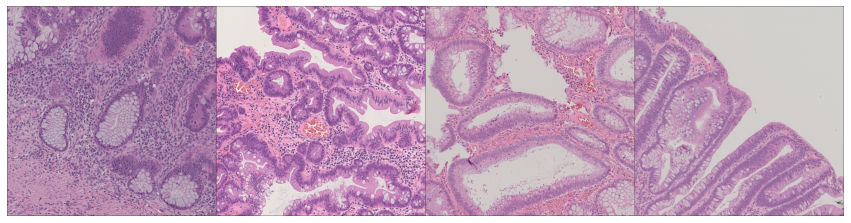

Labels: ['HG', 'LG', 'HG', 'LG']


In [12]:
dataset = unitopatho.UTP(df, path=path, T=transform, subsample=-1, target='grade')
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=4, num_workers=2, pin_memory=True)
batch = next(iter(dataloader))

data, labels = batch
grid = torchvision.utils.make_grid(data)

plt.figure(figsize=(15, 5))
plt.axis('off')
plt.imshow(grid.permute(1, 2, 0))
plt.show()

print('Labels:', list(grade_mapping[l.item()] for l in labels))

## Speed-up loading

Full resolution images take a while to load. We suggest using a package such as [torchdata](https://github.com/szymonmaszke/torchdata) as it provides caching utilities.

## H&E preprocessing

If you are interested in H&E preprocessing such as stain normalization, check out [torchstain](https://github.com/EIDOSlab/torchstain)